In [1]:
import utils, models, data, train
from data import MedakaDataset
from models import AutoEncoderSigmoid, AutoEncoderRelu, AutoEncoderConv, AutoEncoderResNet, AutoEncoderVGGNet
from __init__ import make
from utils import CustomMSELoss
import os
import torch
import wandb
from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import yaml
import matplotlib.pyplot as plt
import glob

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
wandb.login()
utils.set_seeds()
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')
model_dir = '/hps/nobackup/birney/users/esther/medaka-img/models/'

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


In [5]:
project_name = "convnet-ae-pytorch-medaka"
run_name = "ug6e5qe9"

In [6]:
api = wandb.Api()

run = api.run(path = f"ey267-university-of-cambridge/{project_name}/{run_name}")

# Get the latest run
config = run.file("config.yaml").download(replace = True)

In [7]:
with open ('config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
config['criterion']['value']

'MSELoss'

In [9]:
for key in config:
    config[key] = config[key]['value']

config

{'_wandb': {'cli_version': '0.18.3',
  'm': [],
  'python_version': '3.9.1',
  't': {'1': [1, 41, 55],
   '2': [1, 41, 55],
   '3': [1, 2, 16, 23, 55, 61],
   '4': '3.9.1',
   '5': '0.18.3',
   '8': [5],
   '12': '0.18.3',
   '13': 'linux-x86_64'}},
 'architecture': 'Convolutional NN-based autoencoder - train using ilastik masks as input',
 'batch_size': 4,
 'ckpt_dir': '/hps/nobackup/birney/users/esther/medaka-img/models/',
 'ckpt_freq': 20,
 'criterion': 'MSELoss',
 'data_csv': '/nfs/research/birney/users/esther/medaka-img/src_files/train_set_2024-10-03.csv',
 'data_dir': '/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/',
 'direction_csv': '/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv',
 'epochs': 1000,
 'latent_dim': 128,
 'learning_rate': 0.0001,
 'loss_with_mask': False,
 'mask_coef': 'None',
 'model': 'convnet-ae',
 'optimizer': 'adam',
 'project_name': 'convnet-ae-pytorch-medaka',
 'reconstruction_table_freq': 10,
 'train_fro

In [10]:
dataset = MedakaDataset(data_csv=config['data_csv'], direction_csv=config['direction_csv'], src_dir=config['data_dir'], transform=data.transform(resize_shape=(224, 224)), config=config)

train_len = int(len(dataset) * config['train_split'])
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
model, train_loader, val_loader, criterion, optimizer = make(train_dataset, val_dataset, config)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 1, 224, 224]          --
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        2,176
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28]        

In [12]:
checkpoint_files = glob.glob(f"/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/{project_name}/{run.name}/*epoch-999*.pt")

if checkpoint_files:
    checkpoint = torch.load(checkpoint_files[0])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

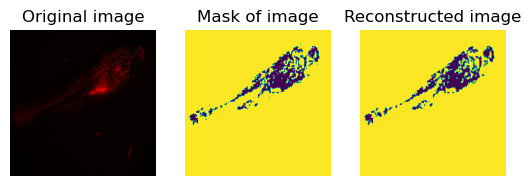

In [13]:
example = dataset[20]
model_output = model(example[2].to(device).unsqueeze(0))

fig, axs = plt.subplots(1, 3)

axs[0].imshow(example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(example[2].permute(1, 2, 0).cpu().numpy())
axs[1].set_title('Mask of image')
axs[1].axis('off')

axs[2].imshow(model_output.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[2].set_title('Reconstructed image')
axs[2].axis('off')

plt.show()

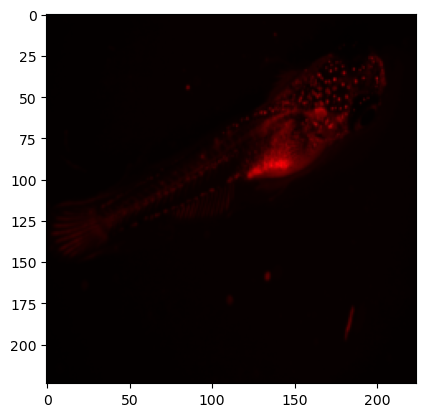

In [14]:
plt.imshow(example[0].permute(1, 2, 0).cpu().numpy())

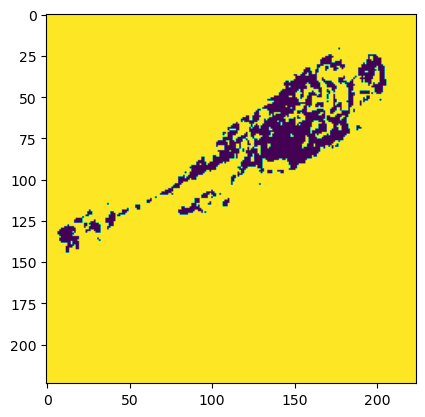

In [15]:
plt.imshow(example[2].permute(1, 2, 0).cpu().numpy())

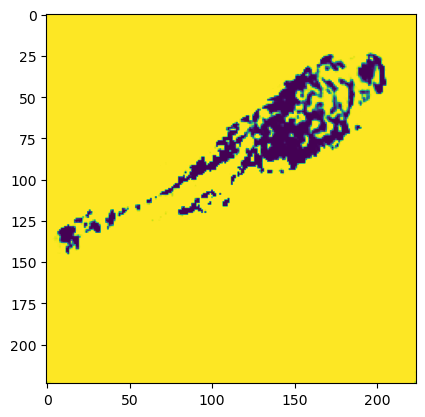

In [16]:
plt.imshow(model_output.detach().cpu().squeeze(0).permute(1, 2, 0))

In [89]:
print(model)

AutoEncoderConv(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (embedding): Linear(in_features=200704, out_features=128, bias=True)
  (deconv1): Sequential(
    (0): Linear(in_features=128, out_features=8

In [94]:
model.encoder = nn.Sequential(*list(model.children())[0:5])

print(model.encoder)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Linear(in_features=200704, out_features=128, bias=True)
)


In [98]:
model.eval()
feature_matrix = {}
counter = 0

for image, image_name, mask in dataset:
    embedding = model.encoder(mask.unsqueeze(0).to(device))
    feature_matrix[image_name] = model.encoder.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (14336x14 and 200704x128)

In [ ]:
print(feature_matrix['PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif'])